In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
import tensorflow.keras.layers as L
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential, model_from_json
import pickle

In [4]:
X = np.load('/content/features_pca.npy', allow_pickle=True)
Y = np.load('/content/labels_pca.npy')

Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,Emotions
0,-65.884684,-35.178243,38.101404,-30.200552,35.057289,-5.153883,29.533186,-1.588773,-9.651186,-5.780506,4.171839,17.835647,-13.757355,-10.295503,22.660619,6.562414,-7.592688,13.090089,-0.599158,8.049421,1.206280,-5.149527,-9.385828,4.274031,5.742261,-2.480529,3.247952,-11.705344,-2.404114,-15.312188,5.103667,4.079261,-0.083974,-13.176376,4.965286,1.522424,-9.596034,-6.870246,2.517891,4.752444,...,-0.096806,-2.678075,-0.956819,-0.294169,2.077515,-1.473132,-0.897300,2.525161,0.376021,0.299973,1.028106,-0.126170,3.780181,0.161949,0.223879,2.839170,0.526324,0.143422,-0.781576,-0.943298,-0.559236,-0.781961,-1.367682,-0.864581,0.022042,-0.477794,-0.604877,-1.218059,2.596023,0.410226,-0.331708,0.734161,2.143200,1.624516,3.029482,-1.663520,0.083727,1.605524,-2.689837,surprise
1,-45.719300,-29.446242,31.037416,-29.401456,34.167973,-4.911666,29.452938,-2.324042,-9.010349,-6.117245,2.556816,16.959913,-12.509867,-11.031505,20.574195,5.808445,-5.552862,8.913286,-2.283579,4.259996,0.820585,-3.848193,-10.068030,4.409559,1.646088,-1.730716,1.201680,-9.985189,-3.553023,-11.053436,4.187041,4.262753,-1.456665,-10.794304,5.869833,3.200510,-8.830075,-6.604151,2.632630,3.974265,...,0.354146,-2.208796,-1.011645,-0.315532,1.597121,-0.955730,-0.873638,2.100041,1.033839,-0.209537,1.362310,-0.375762,3.653763,0.098599,0.968375,2.321424,0.311801,0.314801,-0.527734,-0.977118,-0.486587,-0.807679,-0.972482,-0.744179,-0.281643,-0.026933,-0.790378,-1.170628,2.172215,0.304786,-0.395090,1.086527,2.344977,1.223349,2.752919,-1.108829,0.422801,1.849535,-2.026894,surprise
2,-57.209381,-42.071434,43.778761,-25.513630,31.776891,-12.163566,27.584652,-4.303415,-7.746072,-5.943620,5.509228,17.103532,-6.911090,-9.034861,26.762527,5.974233,-6.905096,7.517527,0.397273,9.689738,-0.033979,-4.146574,-9.084339,1.729312,9.903083,-3.211018,3.349815,-11.183678,-0.427481,-9.303544,8.029040,1.880378,-1.584902,-10.043221,1.269423,0.953714,-8.677537,-2.445487,2.057527,0.636451,...,-1.031018,-1.500614,-1.089679,-0.322855,2.514753,0.110901,0.421783,2.537515,-1.317088,-1.681548,2.783188,-0.049374,0.199950,-0.199952,-0.381307,1.533913,0.603964,-0.893889,-0.986553,-3.096252,0.238256,-0.832239,-0.340412,-1.211291,-0.480384,-1.881016,-0.406968,-0.352865,1.846824,1.615249,-0.617730,-1.850950,2.249919,2.388428,0.037600,-0.516229,0.936772,1.688006,-3.675679,surprise
3,110.053906,-23.185070,16.963946,-8.664025,18.780537,-9.522318,16.575035,-5.048251,-3.639624,-2.819091,-0.965927,6.727769,-2.548651,-8.225596,14.247927,1.334287,2.044392,-2.522034,-1.693299,-2.590449,-0.951675,1.103847,-6.245577,0.546384,-1.604246,-2.423885,-0.564973,-1.187016,-0.758333,4.221449,2.288897,3.799797,-2.521121,-0.982917,3.246165,1.486512,-3.092554,0.585249,4.274700,-3.081474,...,0.231409,-0.973107,-0.966106,0.444467,1.624405,-0.317220,0.118123,0.859587,-0.699168,-0.739032,-0.255782,-0.352055,-1.046315,-1.845699,0.612242,1.636243,2.046839,-0.716540,-0.076058,-1.026895,0.463082,-0.311695,1.391136,0.250366,-1.305733,-1.099812,-0.421006,0.747829,1.010882,0.742613,-0.335427,-0.998612,1.439881,0.828287,-0.188977,0.517193,-0.070124,-0.108791,-2.006490,surprise
4,-75.200161,-1.148727,37.744159,13.962108,34.443483,-0.732024,-32.499937,-15.235384,8.365874,-12.893776,5.590049,3.627200,-3.746904,20.222671,4.505686,-2.403407,-13.518268,-5.637936,0.980907,8.501838,12.423176,-7.351801,-10.136366,-12.355666,-5.269625,21.150840,4.671109,3.285969,-8.666246,-3.654295,2.284231,4.211908,0.854250,-2.410992,9.408839,8.779604,-7.628395,-3.766343,-3.663385,-5.148084,...,-0.954547,1.361273,0.425015,1.442624,-1.806056,1.264319,-0.522683,-1.094557,1.606832,-1.914958,-0.118108,0.253559,1.801997,-0.498223,-1.226125,1.653048,2.539311,-0.664664,1.888542,-0.711931,1.702621,0.

In [5]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
496         False
497         False
498         False
499         False
Emotions    False
Length: 501, dtype: bool


In [6]:
np.sum(Emotions.isna())

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
0,0
1,0
2,0
3,0
4,0
...,...
496,0
497,0
498,0
499,0


In [7]:
X1 = Emotions.iloc[: ,:-1].values
Y1 = Emotions['Emotions'].values

encoder = OneHotEncoder()
Y1 = encoder.fit_transform(np.array(Y1).reshape(-1,1)).toarray()

print(Y1.shape)
print(X1.shape)

(5700, 7)
(5700, 500)


In [16]:
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4560, 500), (4560, 7), (1140, 500), (1140, 7))

In [17]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [18]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4560, 500), (4560, 7), (1140, 500), (1140, 7))

In [19]:
model_checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

In [20]:
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [21]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((4560, 500, 1), (4560, 7), (1140, 500, 1), (1140, 7))

In [22]:
model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    # Add LSTM layer(s) here
    L.LSTM(128, return_sequences=True),
    L.Dropout(0.2),
    L.LSTM(64),
    L.Dropout(0.2),

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary();

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 500, 512)       │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 500, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 250, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 250, 512)       │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 250, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 125, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 125, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 125, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 125, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 63, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 63, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 63, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 32, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,491,783 (9.51 MB)

 Trainable params: 2,487,431 (9.49 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [23]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.1643 - loss: 2.2163 - val_accuracy: 0.2114 - val_loss: 1.9344 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.1815 - loss: 2.0404 - val_accuracy: 0.2114 - val_loss: 1.9335 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.1959 - loss: 1.9776 - val_accuracy: 0.2114 - val_loss: 1.9358 - learning_rate: 0.0010
Epoch 4/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2057 - loss: 1.9579
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.2056 - loss: 1.9579 - val_accuracy: 0.2114 - val_loss: 1.9415 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.2211 - loss: 1.9196 - val_accuracy: 0.2114 - val_loss: 1.9987 - learning_rate: 5.0000e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.2332 - loss: 1.8995 - val

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1926 - loss: 1.9374
Test accuracy:  21.14035040140152 %


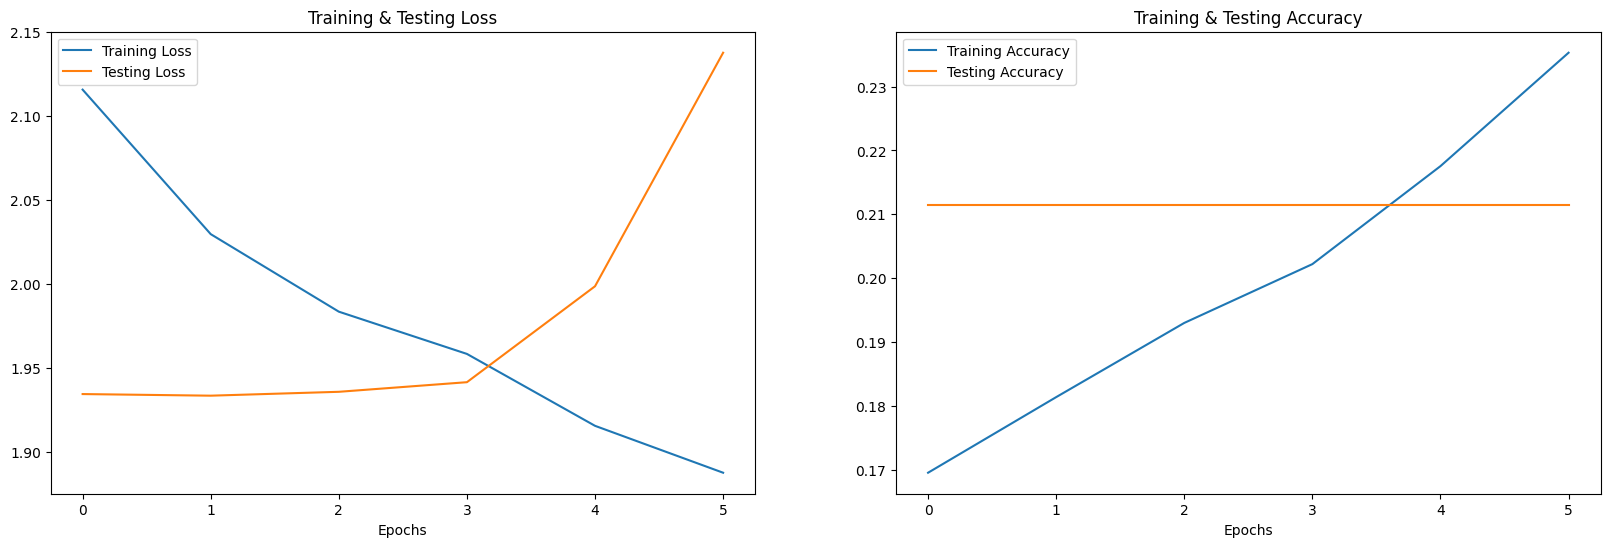

In [25]:
print("Test accuracy: " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

# Get the number of epochs from the training history
epochs = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [26]:
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


,Predicted Labels,Actual Labels
0,neutral,sad
1,neutral,disgust
2,neutral,angry
3,neutral,neutral
4,neutral,fear
5,neutral,disgust
6,neutral,sad
7,neutral,sad
8,neutral,sad
9,neutral,happy


In [27]:
df0.shape

(1140, 2)

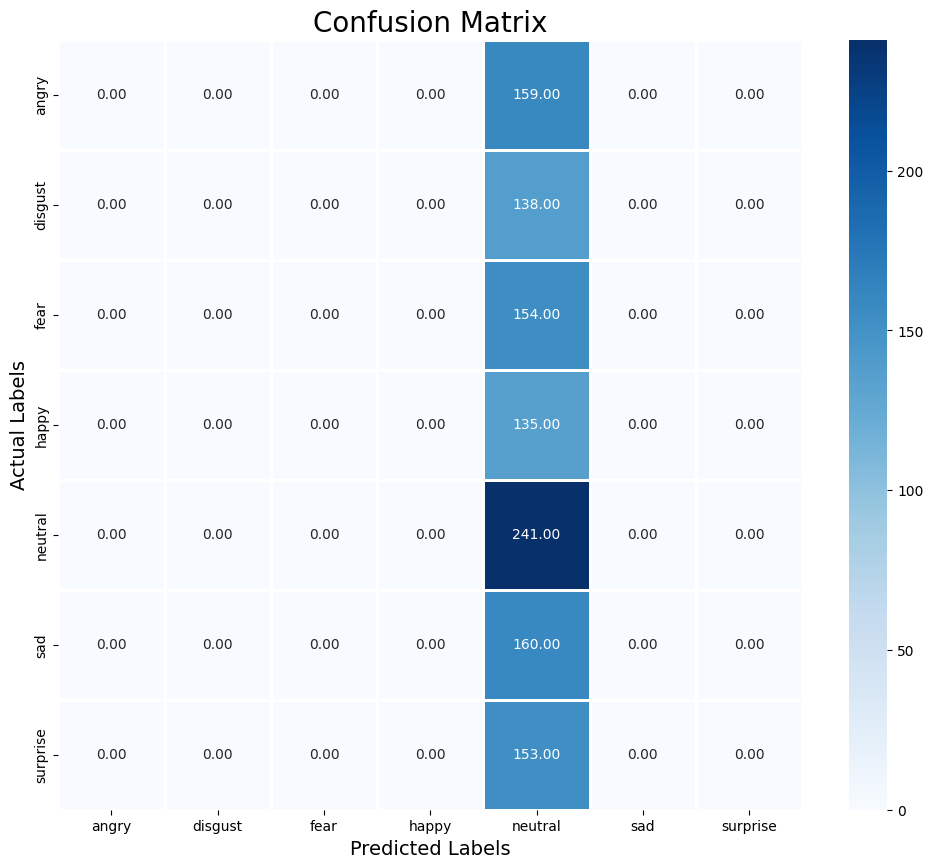

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       159
     disgust       0.00      0.00      0.00       138
        fear       0.00      0.00      0.00       154
       happy       0.00      0.00      0.00       135
     neutral       0.21      1.00      0.35       241
         sad       0.00      0.00      0.00       160
    surprise       0.00      0.00      0.00       153

    accuracy                           0.21      1140
   macro avg       0.03      0.14      0.05      1140
weighted avg       0.04      0.21      0.07      1140



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

In [29]:
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [30]:
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [31]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1926 - loss: 1.9374
compile_metrics: 21.14%


In [32]:
# Saving scaler
with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder.pickle', 'rb') as f:
    encoder2 = pickle.load(f)